In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import image as img
from matplotlib import pyplot as plt
import json

import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader
!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, models

In [2]:
BASE_DIR = '/kaggle/input/eurosat-dataset/EuroSAT'
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10

## Loading data

In [3]:
test_df = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_DIR, 'validation.csv'))

train_df

,Unnamed: 0,Filename,Label,ClassName
0,16257,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,2223,Industrial/Industrial_453.jpg,4,Industrial
4,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation
...,...,...,...,...
18895,4498,HerbaceousVegetation/HerbaceousVegetation_1952...,2,HerbaceousVegetation
18896,1149,Pasture/Pasture_1252.jpg,5,Pasture
18897,15489,AnnualCrop/AnnualCrop_2332.jpg,0,AnnualCrop
18898,6287,Residential/Residential_332.jpg,7,Residential


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18900 non-null  int64 
 1   Filename    18900 non-null  object
 2   Label       18900 non-null  int64 
 3   ClassName   18900 non-null  object
dtypes: int64(2), object(2)
memory usage: 590.8+ KB


In [5]:
with open(os.path.join(BASE_DIR, 'label_map.json'), 'r') as f:
    json_data = f.read()

label_map = json.loads(json_data)
label_map

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [6]:
train_df['Label'].value_counts()

Label
0    2100
2    2100
7    2100
9    2100
1    2100
6    1750
4    1750
3    1750
8    1750
5    1400
Name: count, dtype: int64

### Sample images

## Dataset and Dataloader

In [7]:
train_transforms = transforms.Compose([     
    transforms.ColorJitter(brightness=[0.5, 1.5], contrast=[0.8, 1.2], saturation=[0.8, 1.2]),
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_val_transforms = transforms.Compose([            
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
class Dataset(Dataset):
    def __init__(self, df, transforms=None, with_labels=True):
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        path = os.path.join(BASE_DIR, self.df['Filename'][idx])
        
        image = Image.open(path)
        image = self.transforms(image)
    
        label = self.df['Label'][idx]
        bin_label = 0 if label in [0, 1, 2, 5, 6, 8, 9] else 1
        
        return image, bin_label
    
train_set = Dataset(train_df, transforms=train_transforms)
val_set = Dataset(validation_df, transforms=test_val_transforms)
test_set = Dataset(test_df, transforms=test_val_transforms)

In [9]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

### Sample images

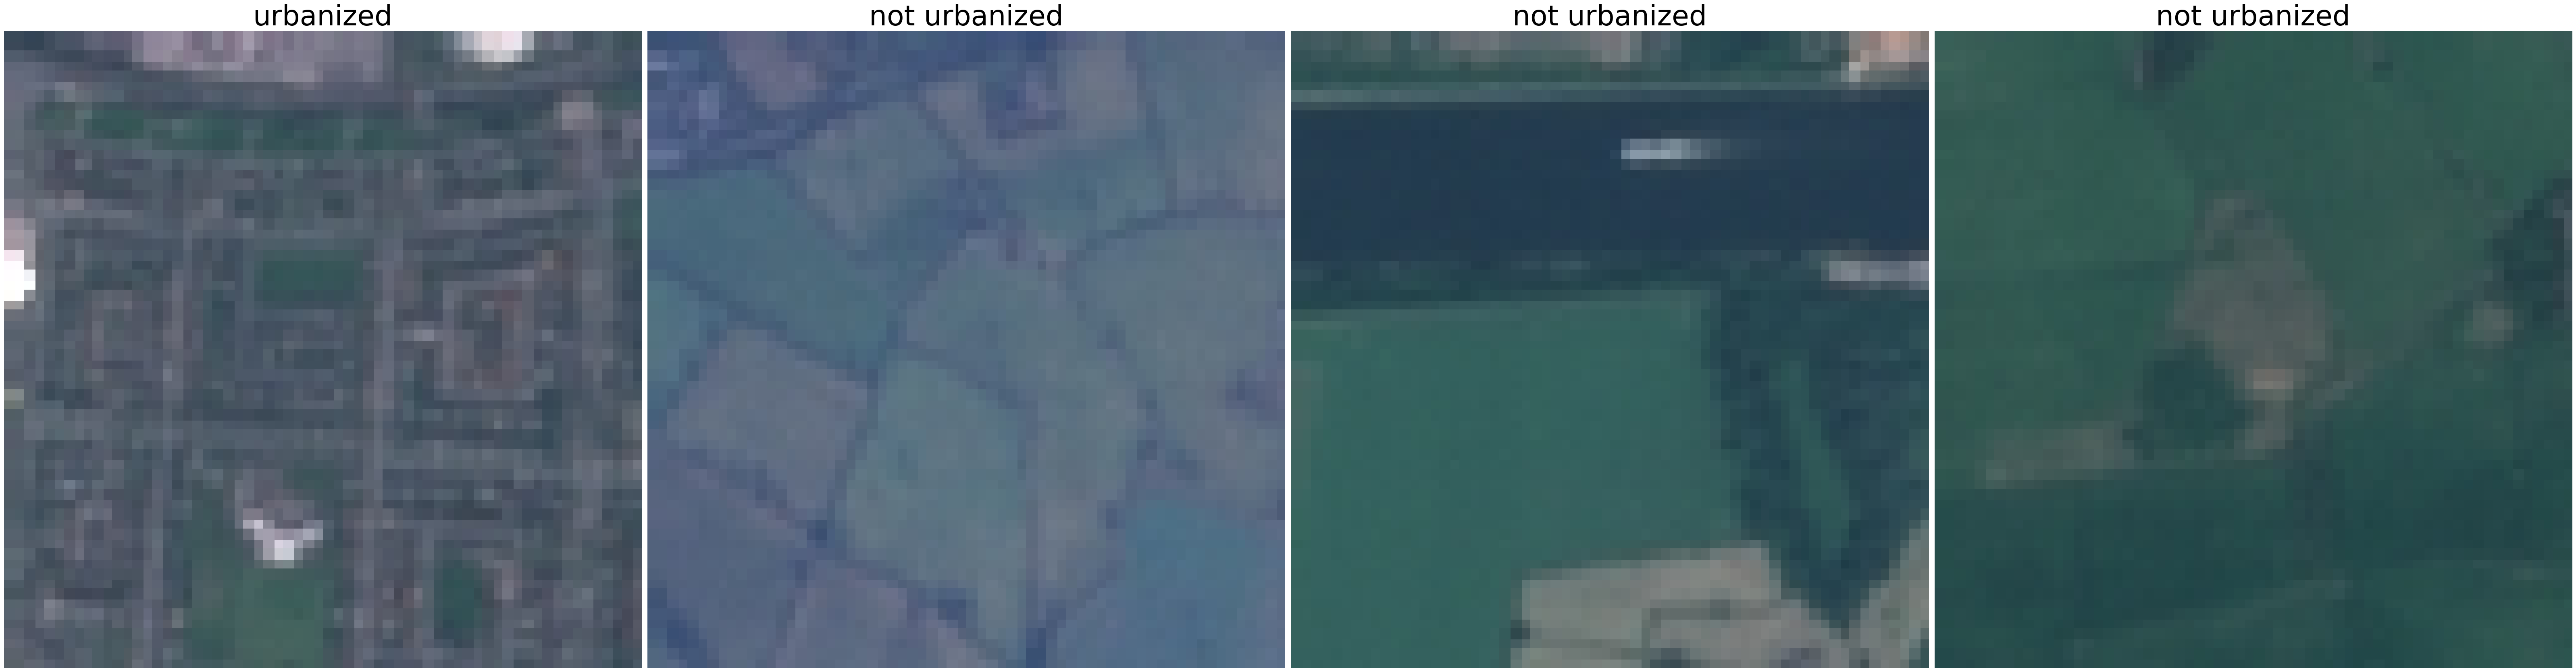

In [10]:
for image_batch, label_batch in val_loader:
    image_batch, label_batch = image_batch[:4], label_batch[:4] 
    fig, axes = plt.subplots(1, 4, figsize=(64, 64))
    axes = [axes]
    for i, data in enumerate(zip(axes[0], image_batch, label_batch)):
        ax, image, label = data
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        label = 'urbanized' if label.item() == 1 else 'not urbanized'
        ax.set_title(label, fontsize=50)

    plt.tight_layout()
    plt.show()
    break

## Model

In [11]:
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.base = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        
        self.hidden1 = torch.nn.Linear(1000, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.hidden2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.hidden3 = torch.nn.Linear(256, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.out = torch.nn.Linear(128, 1)
        self.sig = torch.nn.Sigmoid()
        
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.base(x)
        x = self.hidden1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.hidden2(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = self.hidden3(x)
        x = self.dropout(x)
        x = self.bn3(x)
        x = self.out(x)
        out = self.sig(x)
        
        return out

model = Model()
model = model.to(DEVICE)
summary(model, (3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 122MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters())

In [13]:
def accuracy(pred, targ):
    pos = 0
    for pred, targ in zip(pred, targ):
        if float(round(pred.item())) == targ.item():
            pos += 1
    return pos/BATCH_SIZE

In [14]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

es = EarlyStopping(2, 0.01)

## Training

In [15]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    print('\n ----------------------------------')
    print(f'EPOCH: {epoch + 1}/{NUM_EPOCHS}')
        
    train_loss = 0.0
    train_acc = 0.0
    validation_loss = 0.0
    val_acc = 0.0
    
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        out = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        
        loss = criterion(out, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy(out, labels)
        
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    print(f'train loss: {round(train_loss, 3)}')
    
    train_acc = train_acc/len(train_loader)
    train_accs.append(train_acc)
    print(f'train accuracy: {round(train_acc, 3)}\n')
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            out = model(images)
            
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            loss = criterion(out, labels)
            
            validation_loss += loss.item()
            val_acc += accuracy(out, labels)
            
    validation_loss = validation_loss/len(val_loader)
    val_losses.append(validation_loss)
    print(f'validation loss: {round(validation_loss, 3)}')
    
    val_acc = val_acc/len(val_loader)
    val_accs.append(val_acc)
    print(f'validation accuracy: {round(val_acc, 3)}')
    
    if es.early_stop(validation_loss):
        print('validation loss is not decresing - training stopped')
        break


 ----------------------------------
EPOCH: 1/10
train loss: 0.16
train accuracy: 0.943

validation loss: 0.274
validation accuracy: 0.875

 ----------------------------------
EPOCH: 2/10
train loss: 0.08
train accuracy: 0.97

validation loss: 0.072
validation accuracy: 0.957

 ----------------------------------
EPOCH: 3/10
train loss: 0.063
train accuracy: 0.977

validation loss: 0.241
validation accuracy: 0.896

 ----------------------------------
EPOCH: 4/10
train loss: 0.057
train accuracy: 0.976

validation loss: 0.038
validation accuracy: 0.967

 ----------------------------------
EPOCH: 5/10
train loss: 0.046
train accuracy: 0.982

validation loss: 0.049
validation accuracy: 0.965

 ----------------------------------
EPOCH: 6/10
train loss: 0.043
train accuracy: 0.983

validation loss: 0.032
validation accuracy: 0.969

 ----------------------------------
EPOCH: 7/10
train loss: 0.038
train accuracy: 0.985

validation loss: 0.044
validation accuracy: 0.967

 ---------------------

## Test

In [16]:
test_loss = 0.0
test_acc = 0.0

for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
            
    out = model(images)
    
    labels = labels.unsqueeze(1)
    labels = labels.float()
            
    loss = criterion(out, labels)
    
    test_loss += loss.item()
    test_acc += accuracy(out, labels)
    
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
    
print("TEST")
print(f'Loss: {test_loss}')
print(f'Accuracy: {test_acc}')

TEST
Loss: 0.02724857650834813
Accuracy: 0.9495738636363636


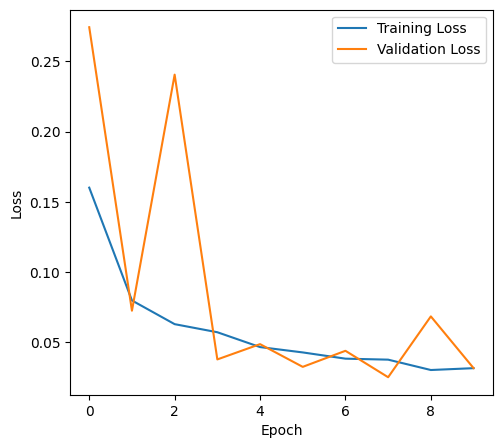

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

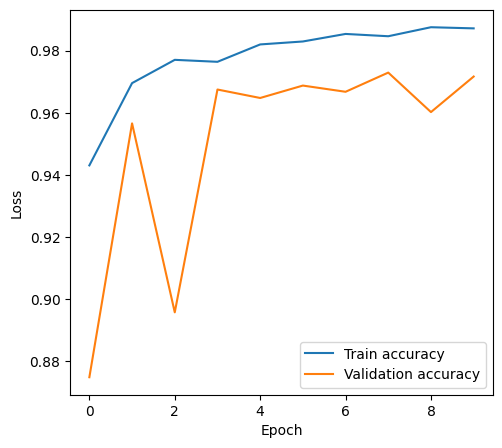

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Save model

In [19]:
torch.save(model.state_dict(), 'model.pth')